<a href="https://colab.research.google.com/github/grgicmatko/OSU/blob/master/RUSU_LV7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sijamsko učenje

Sijamsko učenje (*siamese learning*) je tehnika u strojnom učenju koja koristi paralelne neuronske mreže sa zajedničkim težinama kako bi naučile efikasnu reprezentaciju ulaznih podataka. Osnovna ideja sijamskog učenja je omogućiti mreži učenje sličnosti (*similarity learning*) između parova ulaznih primjera. Primjene uključuju prepoznavanje lica, prepoznavanje otiska prsta, verifikacija potpisa, grupiranje podataka, praćenje objekata u video zapisima itd.

Sijamska mreža sastoji se od dvije identične mreže koje dijele težine. Te mreže primaju različite ulaze te generiraju reprezentacije u nižedimenzionlanom prostori (*embeddings*) za svaki od ulaza. Zatim se mjeri udaljenost između *embeddinga*.

Prilikom treninga mreža treba naučiti generirati takve reprezentacije da je za ulaze iste klase (pozitivni parovi) udaljenost između reprezentacija mala, a za ulaze različitih klasa (negativni parovi) udaljenost između reprezentacija veća.

## Kontrastni gubitak (*constrastive loss*)

Kontrastni gubitak definiran je na sljedeći način:
$$L(x_1, x_2) = y * d(f(x_1), f(x_2))^2 + (1 - y) * max(0, m^2 - d(f(x_1), f(x_2))^2)$$

$y$ je 1 ako su ulazne slike iste klase, 0 inače. $d(f(x_1), f(x_2))$ predstavlja udaljenost između *embeddinga* ulaznih slika. $m$ je proizvoljno odabrana margina, ako nam je udaljenost između reprezentacija negativnih parova veća od $m^2$, vrijednost funkcije gubitka će biti 0.

Za mjeru udaljenosti se može koristiti L2 udaljenost:
$$d(a, b) = \sqrt{\sum_{i=1}^n{(a_i - b_i)^2}}$$

Kako bi udaljenost između reprezentacija bila ograničena, često se reprezentacije normaliziraju. Na ovaj način će sve reprezentacije biti točke na jediničnoj kružnici. Normiranje vektora:
$$v_{norm} = \frac{v}{||v||_2}$$

## Podatkovni skup

Podatkovni skupovi za primjene za koje se koristi sijamsko učenje često imaju velik broj klasa i mali broj primjera za svaku klasu, stoga bi se nasumičnim odabiranjem parova dobio jako velik broj negativnih parova. Zbog ovoga bi mreža vrlo teško naučila raditi s pozitivnim parovima. Jedan od načina da se ovo riješi je da se generira takav podatkovni skup gdje je podjednak broj pozitivnih i negativnih parova.

U nastavku je implementirano generiranje jednog ovakvog podatkovnog skupa na temelju [Omniglot](https://pytorch.org/vision/main/generated/torchvision.datasets.Omniglot.html) podatkovnog skupa.

In [37]:
## Importing useful libraries
import os
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision
from torchsummary import summary

import matplotlib.pyplot as plt
from imageio.v2 import imread
%matplotlib inline

from tqdm.notebook import tqdm

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

from torch.utils.tensorboard import SummaryWriter

%load_ext tensorboard

Device cuda
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [38]:
batch_size = 128

In [39]:
import random
from torch.utils.data import DataLoader, Dataset

class MatchedDataset(Dataset):
  def __init__(self, original_dataset):
    self.grouped = {}
    self.size = len(original_dataset)
    for i, c in original_dataset:
      if c not in self.grouped:
        self.grouped[c] = []
      self.grouped[c].append(i)

    self.classes = list(self.grouped.keys())

  def __getitem__(self, index):
    cls0 = random.choice(self.classes)
    image0_idx = random.randint(0, len(self.grouped[cls0]) - 1)
    image0 = self.grouped[cls0][image0_idx]
    ## select random label, 1 for same class, 0 for different class
    label = random.randint(0,1)
    if label:
      ## select a different image of the same class
      while True:
        image1_idx = random.randint(0, len(self.grouped[cls0]) - 1)
        if image0_idx != image1_idx:
          image1 = self.grouped[cls0][image1_idx]
          break
    else:
      ## select a random image from a different class
      while True:
        cls1 = random.choice(self.classes)
        if cls0 != cls1:
          image1 = random.choice(self.grouped[cls1])
          break

    return image0, image1, label

  def __len__(self):
    return self.size

In [40]:
%%capture
import torchvision.transforms as transforms
from torchvision.datasets import Omniglot

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_original_dataset = Omniglot(root='./data/Omniglot', download=True, background=True, transform=img_transform)
train_dataset = MatchedDataset(train_original_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_original_dataset = Omniglot(root='./data/Omniglot', download=True, background=False, transform=img_transform)
test_dataset = MatchedDataset(test_original_dataset)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

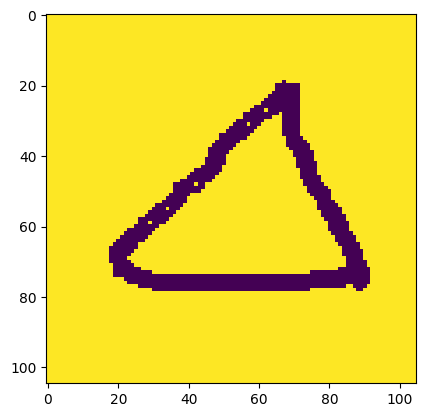

In [41]:
plt.imshow(next(iter(train_dataloader))[0][0].numpy().transpose(1, 2, 0))

## Zadaci

1. Proučite podatkovni skup, prikažite primjere pozitivnih i negativnih parova.

2. Prilagodite neuronsku mrežu iz 3. laboratorijske vježbe kako bi primala dvije slike iz Omniglot podatkovnog skupa i generirala reprezentacije tih ulaza. Za ovo je potrebno izbaciti posljednji, klasifikacijski, sloj te uklonite aktivacijsku funkciju novog posljednjeg sloja. Izlaze iz posljednjeg sloja [normalizirajte](https://pytorch.org/docs/stable/generated/torch.nn.functional.normalize.html).

3. Implementirajte funkciju kontrastnog gubitka.

4. Implementirajte funkciju za treniranje te trenirajte mrežu.

5. Evaluirajte istreniranu mrežu na podacima za testiranje. Funkcija za evaluaciju treba računati točnost, preciznost i odziv. Prilikom evaluacije, potrebno je odabrati prag minimalne udaljenosti za koje će ulazne slike biti klasificirane kao različite. Evaluirajte mrežu s različitim vrijednostima te skicirajte vrijednosti točnosti, preciznosti i odziva u ovisnosti o pragu. Pomoću ove krivulje, odaberite optimalnu vrijednost praga za klasifikaciju.

Text(0.5, 1.0, 'Image 2')

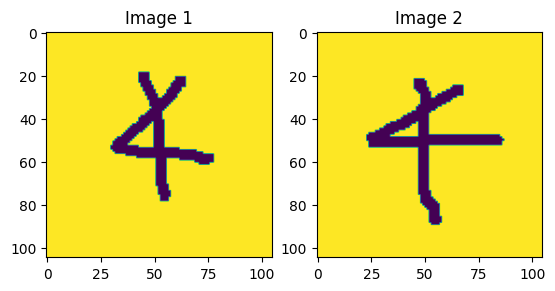

In [58]:
while True:
    img1, img2, label = train_dataset[0]

    # Check if the label has a value of 1
    if label == 1:
        break  # Exit the loop if the condition is met

fig, axes = plt.subplots(1, 2)

# Plot the first image on the left subplot
axes[0].imshow(img1.numpy().transpose(1, 2, 0))
axes[0].set_title('Image 1')

# Plot the second image on the right subplot
axes[1].imshow(img2.numpy().transpose(1, 2, 0))
axes[1].set_title('Image 2')

In [49]:
class SiameseNN(nn.Module):

    def __init__(self):
        super().__init__()
        # Initialize the modules we need to build the network
        self.pool=nn.MaxPool2d(2,2)
        self.conv1=nn.Conv2d(1,16,3,padding='same')
        self.conv2=nn.Conv2d(16,32,3,padding='same')
        self.conv3=nn.Conv2d(32,32,3,padding='same')
        self.conv4=nn.Conv2d(32,64,3,padding='same')
        self.conv5=nn.Conv2d(64,64,3,padding='same')
        self.conv6=nn.Conv2d(64,128,3,padding='same')
        self.conv7=nn.Conv2d(128,128,3,padding='same')
        self.conv8=nn.Conv2d(128,128,3,padding='same')
        self.conv9=nn.Conv2d(128,512,3,padding='same')
        self.conv10=nn.Conv2d(512,512,3,padding='same')
        self.conv11=nn.Conv2d(512,512,3,padding='same')
        self.conv12=nn.Conv2d(512,512,3,padding='same')
        self.flatten=nn.Flatten()
        self.actfn=nn.ReLU()
        self.dropout=nn.Dropout(p=0.5)
        self.dropout2d=nn.Dropout(p=0.5)
        self.batchnorm1=nn.BatchNorm2d(16)
        self.batchnorm2=nn.BatchNorm2d(32)
        self.batchnorm3=nn.BatchNorm2d(32)
        self.batchnorm4=nn.BatchNorm2d(64)
        self.batchnorm5=nn.BatchNorm2d(64)
        self.batchnorm6=nn.BatchNorm2d(128)
        self.batchnorm7=nn.BatchNorm2d(128)
        self.batchnorm8=nn.BatchNorm2d(128)
        self.batchnorm9=nn.BatchNorm2d(512)
        self.batchnorm10=nn.BatchNorm2d(512)
        self.batchnorm11=nn.BatchNorm2d(512)
        self.batchnorm12=nn.BatchNorm2d(512)
        self.finalactfn=nn.Tanh()

    def forward1(self, x):
        # Perform the calculation of the model to determine the prediction
        x=self.conv1(x)
        x=self.batchnorm1(x)
        x=self.actfn(x)

        x=self.conv2(x)
        x=self.batchnorm2(x)
        x=self.actfn(x)

        x=self.pool(x)
        x=self.dropout2d(x)

        x=self.conv3(x)
        x=self.batchnorm3(x)
        x=self.actfn(x)

        x=self.conv4(x)
        x=self.batchnorm4(x)
        x=self.actfn(x)

        x=self.pool(x)
        x=self.dropout2d(x)

        x=self.conv5(x)
        x=self.batchnorm5(x)
        x=self.actfn(x)

        x=self.conv6(x)
        x=self.batchnorm6(x)
        x=self.actfn(x)

        x=self.pool(x)
        x=self.dropout2d(x)

        x=self.conv7(x)
        x=self.batchnorm7(x)
        x=self.actfn(x)

        x=self.conv8(x)
        x=self.batchnorm8(x)
        x=self.actfn(x)

        x=self.conv9(x)
        x=self.batchnorm9(x)
        x=self.actfn(x)

        x=self.pool(x)
        x=self.dropout2d(x)

        x=self.conv10(x)
        x=self.batchnorm10(x)
        x=self.actfn(x)

        x=self.conv11(x)
        x=self.batchnorm11(x)
        x=self.actfn(x)

        x=self.conv12(x)
        x=self.batchnorm12(x)
        x=self.actfn(x)

        x=self.pool(x)

        x=self.flatten(x)

        x = F.normalize(x)
        return x

    def forward(self, x1, x2):
        output1 = self.forward1(x1)
        output2 = self.forward1(x2)
        return output1, output2

In [ ]:
def train_model(model, optimizer, train_data_loader, loss_module, num_epochs=100):
    # Set model to train mode
    model_plotted = False
    model.train()

    # Training loop
    for epoch in range(num_epochs):
        epoch_loss = 0.0


        for data_inputs1, data_inputs2, data_labels in tqdm(train_data_loader, 'Epoch %d'%(epoch + 1)):

            ## Step 1: Move input data to device
            data_inputs1, data_inputs2, data_labels = data_inputs1.to(device), data_inputs2.to(device), data_labels.to(device)

            ## Step 2: Run the model on the input data
            outputs1, outputs2 = model(data_inputs1, data_inputs2)

            ## Step 3: Calculate the loss
            loss = loss_module(outputs1, outputs2, data_labels)

            ## Step 4: Perform backpropagation
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()

            epoch_loss += loss.item() * len(data_inputs1)

        # Add average loss to TensorBoard
        epoch_loss /= len(train_data_loader.dataset)

        print(f"Training loss of the model: {100.0*epoch_loss:4.2f}%")

In [42]:
# 3. Implementirajte funkciju kontrastnog gubitka
def contrastive_loss(device, m = 1):
  def loss(embedding1, embedding2, label):
    ## TODO: Implement the contrastive loss
    dist = F.pairwise_distance(embedding1,embedding2)
    l = label * torch.pow(dist,2) + (1 - label) * torch.clamp(m*m - torch.pow(dist,2),min=0.0)
    return torch.mean(l)
  return loss

In [43]:
loss_module = contrastive_loss(device, 1)

In [44]:
## Check if you implemented the loss correctly, the correct output should be 0.2750

loss_module(torch.Tensor([[1, 1, 1], [0, 1, 1]]).to(device), torch.Tensor([[1, 0.8, 0.9], [0, 0.5, 0.5]]).to(device), torch.Tensor([1, 0]).to(device))

tensor(0.2750, device='cuda:0')

In [ ]:
def visualize_results(thresholds, results):
  # thresholds is an array of values of the threshold, e.g. np.arange(0, 2, 0.1)
  # results is an array of shape (len(thresholds), 3) where
  # results[:,0] is the values of accuracy given the different thresholds
  # and results[:,1] and results[:,2] are similarly values of precision and recall

  fig, ax = plt.subplots()
  ax.plot(thresholds, results[:,0], c='green', label='accuracy')
  ax.plot(thresholds, results[:,1], c='blue', label='precision')
  ax.plot(thresholds, results[:,2], c='orange', label='recall')
  plt.legend(loc="lower right")
  plt.show()

In [ ]:
def visualize(model, dataloader, n = 6):
  ## visualize some examples of input pairs and the distance between their embeddings
  fig = plt.figure(constrained_layout=True, figsize=(4, 2.2*n))
  subfigs = fig.subfigures(nrows=n, ncols=1)

  for i in range(n):
    data = next(iter(dataloader))
    data_inputs1 = data[0][i].unsqueeze(0)
    data_inputs2 = data[1][i].unsqueeze(0)
    data_labels = data[2][i].unsqueeze(0)

    data_inputs1 = data_inputs1.to(device)
    data_inputs2 = data_inputs2.to(device)
    data_labels = data_labels.to(device)

    embedding1, embedding2 = model((data_inputs1, data_inputs2))
    dist = torch.linalg.norm(embedding1 - embedding2, dim = 1)

    subfig = subfigs[i]
    subfig.suptitle('Distance: %.4f, Label: %d'%(dist, data_labels), size='small')
    ax = subfig.subplots(nrows=1, ncols=2)
    img1_ = data_inputs1[0].cpu().numpy().transpose(1, 2, 0)
    ax[0].imshow(img1_)
    img2_ = data_inputs2[0].cpu().numpy().transpose(1, 2, 0)
    ax[1].imshow(img2_)
  plt.show()